In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import wfdb
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from scipy.signal import butter, sosfilt, sosfreqz, ShortTimeFFT, get_window

In [110]:
path = '~/Desktop/ptb-xl/'
dataset = pd.read_json(path+'updated_ptbxl_database.json')
dataset = dataset[['filename_lr', 'filename_hr', 'MI', 'STTC', 'CD', 'HYP', 'AD']]

In [111]:
leads = ['I', 'II', 'V2']
classes = ['MI', 'STTC', 'CD', 'HYP', 'AD']
batch_size = 32


# Multilabel Stratification
Since this is a mutli-label classification problem, it's important to split the data with respect to
each of the classes to ensure a well rounded training and testing run. This [repo](https://github.com/trent-b/iterative-stratification) implements this [paper](https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10), which is an iterative sampling method that is far better than random sample for problems like this. This package requires python 3.9 in order to work.

In [112]:
train_percentage = 0.70
test_percentage = 0.15
validation_percentage = 0.15

assert(train_percentage + test_percentage + validation_percentage == 1)

# Extract X and y
X = dataset[['filename_lr', 'filename_hr']]
y = dataset[['MI', 'STTC', 'CD', 'HYP', 'AD']]

# Train/Test split
splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=0)
train_indices, test_indices = next(splitter.split(X, y))

# Train/Validation split
splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=validation_percentage / (1 - test_percentage), random_state=0)
train_indices, validation_indices = next(splitter.split(X.iloc[train_indices], y.iloc[train_indices]))

# Assign splits
X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
X_validate, y_validate = X.iloc[validation_indices], y.iloc[validation_indices]
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

# Check split sizes
print(len(X_train), len(X_validate), len(X_test))

15243 3295 3261


# Data Loading Pipeline
In this section, we define a number of functions that will be used to efficiently load, transform and format the batches of signals. Using the rational discussed in this [paper](https://www.sciencedirect.com/science/article/pii/S174680942400199X#sec4), all but three leads from each signal sample will be dropped, keeping leads I, II and V2. This will save a computational cost and make the training more efficient. A band pass filter will then be applied to each signal to trim out baseline wander noise and high frequency noise above 45hz. A spectrogram operation will be applied to each lead, then the leads will be stacked on top of each other to create a (3, 1000, 45) matrix. This will be passed into the network.

1. Load only 3 leads of the signal
2. Apply bandpass filter
3. Apply spectrogram (STFT)
4. Combine signals into a matrix [signals, timesteps, frequency steps] (3, 1000, n) n is undecided for now

### 1: Loading the signals

In [113]:
def load_batch(df, path='ptb-xl/', sampling_rate=100):
    df_files = df.filename_lr if sampling_rate == 100 else df.filename_hr
    data = np.array(
        [
            wfdb.rdrecord(path+f, channel_names=leads, return_res=32)
            .to_dataframe()
            .T
            .to_numpy()
            for f in df_files
        ]
    )
    labels = df[classes].to_numpy()
    return data, labels

### 2: Designing the bandpass filter
I have some background in signal processing due to my undergraduate degree in computer engineering. I had ChatGPT generate me some code to help design the filter.

/tmp/ipykernel_552552/1951728802.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w, 20 * np.log10(abs(h)))


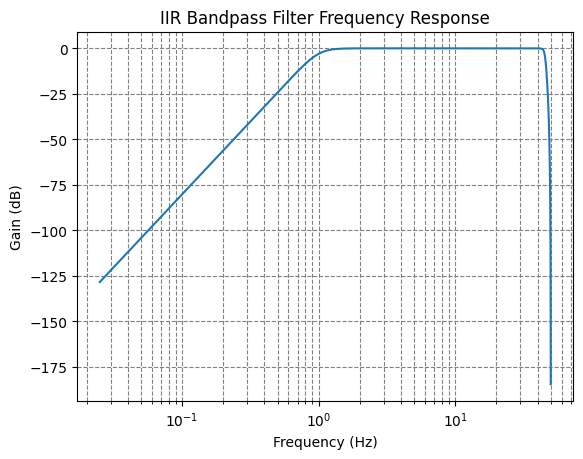

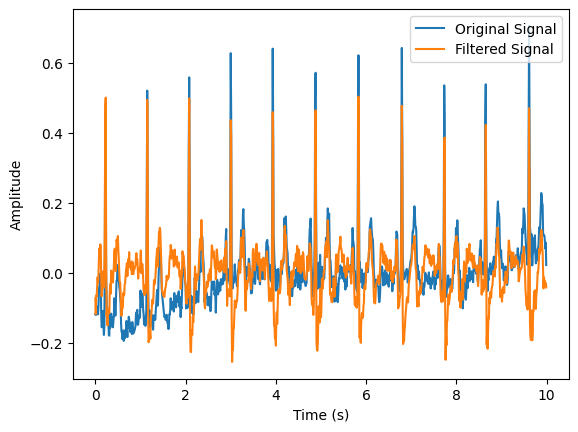

In [114]:
# Band pass filter
lowcut = 1.0          # Lower cutoff frequency (Hz)
highcut = 45.0        # Upper cutoff frequency (Hz)
fs = 100.0            # Sampling frequency (Hz)
order = 4             # Filter order (higher = steeper rolloff)

# Define the IIR bandpass filter
def design_iir_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')  # Second-order sections
    return sos

# Design the filter
sos = design_iir_bandpass(lowcut, highcut, fs, order)

# Visualize frequency response
w, h = sosfreqz(sos, worN=2000, fs=fs)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('IIR Bandpass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(which='both', linestyle='--', color='gray')
plt.show()

# Apply the filter to a signal (example)

def apply_filter(signal, sos):
    return sosfilt(sos, signal)

seconds = 10.0
t = np.linspace(0, seconds, int(fs * seconds), endpoint=False)  # 1 second of data
data, labels = load_batch(dataset.iloc[:1])
data = data[0][0][:int(fs * seconds)]
filtered_signal = apply_filter(data, sos)

# Plot original vs. filtered signal
plt.plot(t, data, label="Original Signal")
plt.plot(t, filtered_signal, label="Filtered Signal")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


### 3: Apply Spectrogram

In [115]:
# Standard deviation of 2
nperseg = fs * 1  # Length of each segment, 2 seconds in this case
hop = 3  # Overlap between segments, 50% hop in this case

w = get_window(('gaussian', 2), nperseg)
sft = ShortTimeFFT(w, hop, fs=fs, mfft=150)

def apply_spectrogram(signal, sft=sft):
    spectrogram = sft.spectrogram(signal)
    return spectrogram

In [116]:
def preprocess_batch(df, sos, sft, sampling_rate=fs):
    # Load data and labels
    data, labels = load_batch(df, sampling_rate=sampling_rate)
    filtered_data = sosfilt(sos, data, axis=-1)
    spectrogram_data = np.apply_along_axis(func1d=apply_spectrogram, axis=2, arr=filtered_data, sft=sft)
    
    return spectrogram_data, labels

In [117]:
data, labels = preprocess_batch(df=dataset[:32], sft=sft, sos=sos)
print(data.shape)

(32, 3, 76, 366)


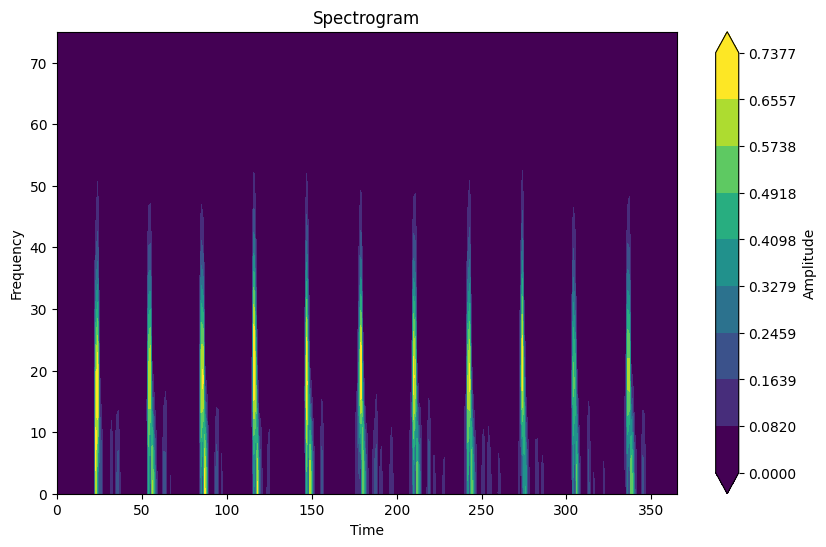

In [118]:
import matplotlib.colors as mcolors

# Define a discrete colormap
levels = np.linspace(data[0][0].min(), data[0][0].max(), 10)  # Adjust number of levels
cmap = mcolors.ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(levels) - 1)))

# Plot with the discrete colormap
plt.figure(figsize=(10, 6))
plt.contourf(data[0][0], levels=levels, cmap=cmap, extend='both')
plt.colorbar(label='Amplitude', ticks=levels)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()

# Build the Model

In [ ]:
def build_model(input_shape):
    # Build a convolutional neural network (CNN) for feature extraction
    model = models.Sequential()

    # Conv layers for feature extraction
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from convolutions for dense layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer with 5 classes (multi-class classification)
    model.add(layers.Dense(5, activation='softmax'))

    return model